Info    : Reading 'convergence/r1.msh'...
Info    : 26 entities
Info    : 2368 nodes
Info    : 4738 elements
Info    : Done reading 'convergence/r1.msh'
Plot saved as convergence/r1_grad_y_uh_plate_plot.png


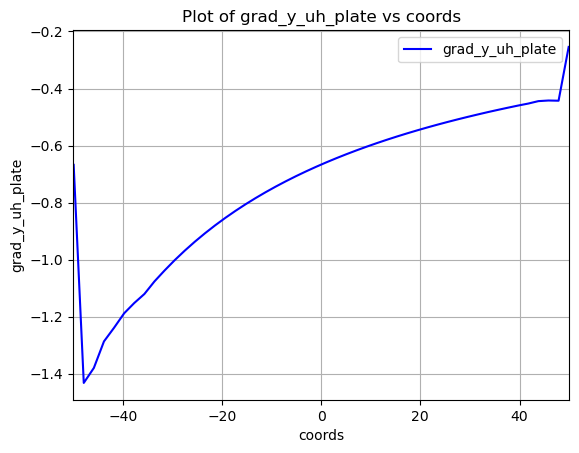

Info    : Reading 'convergence/r3.msh'...
Info    : 26 entities
Info    : 5520 nodes
Info    : 11042 elements
Info    : Done reading 'convergence/r3.msh'
Plot saved as convergence/r3_grad_y_uh_plate_plot.png


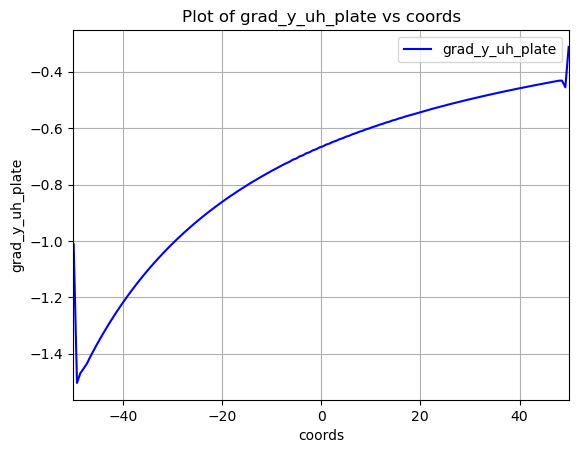

Info    : Reading 'convergence/r5.msh'...
Info    : 26 entities
Info    : 8879 nodes
Info    : 17760 elements
Info    : Done reading 'convergence/r5.msh'
Plot saved as convergence/r5_grad_y_uh_plate_plot.png


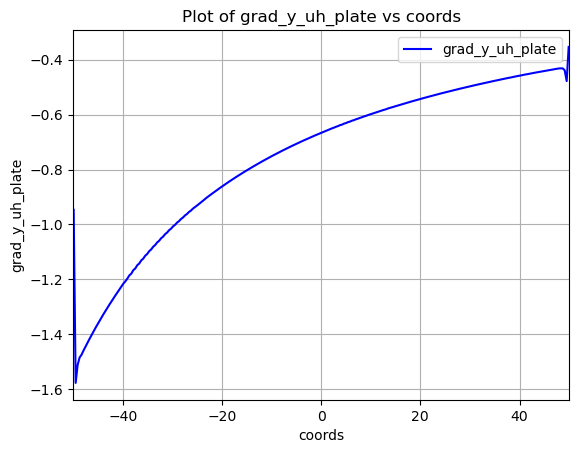

Info    : Reading 'convergence/r7.msh'...
Info    : 26 entities
Info    : 12541 nodes
Info    : 25084 elements
Info    : Done reading 'convergence/r7.msh'
Plot saved as convergence/r7_grad_y_uh_plate_plot.png


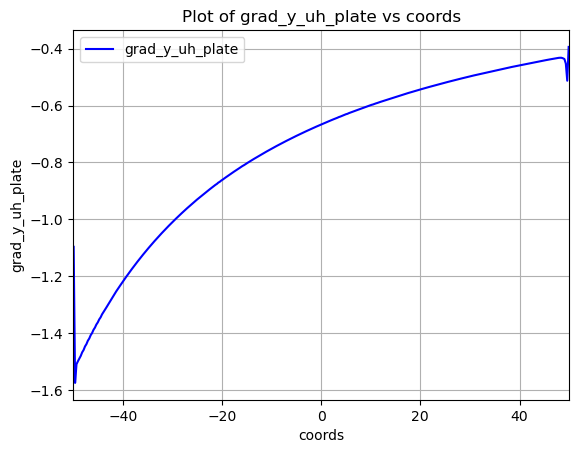

In [ ]:
def solve_and_plot_grad(path, name):
    # read a mesh from file capacitor.msh
    from mpi4py import MPI
    from dolfinx.io import gmshio
    from mesh_generation import generate_mesh_from_geo
    import os
    import subprocess
    with open(os.devnull, 'w') as devnull:
        subprocess.run(["gmsh", "-2", str(path)+str(name)+".geo"], stdout=devnull, stderr=devnull)
    domain, cell_tags, facet_tags = gmshio.read_from_msh(str(path)+str(name)+".msh", MPI.COMM_WORLD, 0, gdim=2)


    # define finite element function space
    from dolfinx.fem import functionspace
    import numpy as np
    V = functionspace(domain, ("Lagrange", 1))

    # identify the boundary (create facet to cell connectivity required to determine boundary facets)
    from dolfinx import default_scalar_type
    from dolfinx.fem import (Constant, dirichletbc, locate_dofs_topological)
    from dolfinx.fem.petsc import LinearProblem
    tdim = domain.topology.dim
    fdim = tdim - 1
    domain.topology.create_connectivity(fdim, tdim)

    # Find facets marked with 2 and 3 (the two rectangles)
    facets_rect1 = np.concatenate([facet_tags.find(10), facet_tags.find(11)])
    facets_rect2 = facet_tags.find(12)

    # Locate degrees of freedom
    dofs_rect1 = locate_dofs_topological(V, fdim, facets_rect1)
    dofs_rect2 = locate_dofs_topological(V, fdim, facets_rect2)

    # Define different Dirichlet values
    u_rect1 = Constant(domain, 0.0)
    u_rect2 = Constant(domain, 1.0)

    # Create BCs
    bc1 = dirichletbc(u_rect1, dofs_rect1, V)
    bc2 = dirichletbc(u_rect2, dofs_rect2, V)

    bcs = [bc1, bc2]

    # trial and test functions
    import ufl
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # source term
    from dolfinx import default_scalar_type
    from dolfinx import fem
    f = fem.Constant(domain, default_scalar_type(0.0))

    # variational problem
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    L = f * v * ufl.dx

    # assemble the system
    from dolfinx.fem.petsc import LinearProblem
    problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()



    # APPROXIMATION OF THE GRADIENT OF THE SOLUTION

    import ufl

    # Define the vector function space for the gradient
    V_vec = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

    # Define the trial and test functions for the vector space
    u_vec = ufl.TrialFunction(V_vec)
    v_vec = ufl.TestFunction(V_vec)

    # Define the gradient of the solution
    grad_u = ufl.grad(uh)

    # Define the bilinear and linear forms
    a_grad = ufl.inner(u_vec, v_vec) * ufl.dx
    L_grad = ufl.inner(grad_u, v_vec) * ufl.dx

    # Assemble the system
    from dolfinx.fem.petsc import LinearProblem
    problem_grad = LinearProblem(a_grad, L_grad, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    grad_uh = problem_grad.solve()


    # PLOTTING THE GRADIENT OF THE SOLUTION ON THE UPPER PLATE

    # Step 1: Find facets with tag 10
    facets10 = facet_tags.find(10)
    dofs10 = locate_dofs_topological(V, fdim, facets10)

    # Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
    x_dofs = V.tabulate_dof_coordinates()[dofs10]
    x_coords = x_dofs[:, 0]
    y_coords = x_dofs[:, 1]

    # Step 3: Evaluate grad_uh at those DOFs
    dim = domain.geometry.dim
    grad_x_uh_values = grad_uh.x.array[0::dim]
    grad_y_uh_values = grad_uh.x.array[1::dim]
    grad_x_uh_plate = grad_x_uh_values[dofs10]
    grad_y_uh_plate = grad_y_uh_values[dofs10]


    # Plot grad_y_uh_plate against coords
    import matplotlib.pyplot as plt
    center_y = 1.5/2
    center_x = 0.0
    coords = np.sign(x_coords) * np.sqrt((x_coords-center_x)**2 + (y_coords-center_y)**2)
    sorted_indices = np.argsort(coords)
    coords = coords[sorted_indices]
    grad_y_uh_plate = grad_y_uh_plate[sorted_indices]
    grad_x_uh_plate = grad_x_uh_plate[sorted_indices]
    plt.plot(coords, grad_y_uh_plate, label="grad_y_uh_plate", color="blue", linestyle="-")
    plt.xlim(-50, 50)
    plt.xlabel("coords")
    plt.ylabel("grad_y_uh_plate")
    plt.title("Plot of grad_y_uh_plate vs coords")
    plt.legend()
    plt.grid(True)
    # Save the plot as an image in the convergence folder
    output_path = os.path.join(path, f"{name}_grad_y_uh_plate_plot.png")
    plt.savefig(output_path)
    print(f"Plot saved as {output_path}")
    plt.show()


solve_and_plot_grad("convergence/", "r1")
solve_and_plot_grad("convergence/", "r3")
solve_and_plot_grad("convergence/", "r5")
solve_and_plot_grad("convergence/", "r7")